# NLP classification with BERT

## TOC:
* [Preparing](#preprocess)
* [Feature engineering](#features)
    * [Basic preprocessing](#basic)
    * [Implicit duplicates](#duplicates)
* [Exploratory Data Analysis](#eda)
    * [Class imbalance](#imbalance)
    * [Frequency analysis](#freq)
    * [Keywords discovery](#keywords)
        * [KeyBERT library](#keybert)
        * [Create custom analysis](#custom)
    * [Text length](#len)
* [Modeling](#model)
    * [Struggle with imbalance](#model-imbalance)
    * [Model based on keywords](#model-keywords)
    * [Logistic regression base frequency features](#lr)
    * [RF, LGBM, XGB...](#boost)
    * [CatBoost](#catboost)
    * [BERT embeddings](#bertemb)
    * [TNSE embedding visualization](#tnse)
    * [Universal sentence encoder](#use)
    * [BERT with fine tuning](#bert-fine)
    * [Ensambling](#ensambling)
    * [Consulation](#model-consulation)
* [Testing](#test)
* [Consulation](#consulation)

Needs a tool that will look for toxic comments and submit them for moderation. Labeled dataset is provided. Target metric is F1 must be more then 0.75

We tried several models for comparison (TS-IDF, BERT, USE, e.t.c). We will use local machine and Colab for training.

In [1]:
# pip install pymystem3

In [2]:
# pip install spacy

In [3]:
# !spacy download en

In [4]:
# pip install swifter

In [5]:
# pip install keybert

In [6]:
# pip install -U imbalanced-learn

In [7]:
# pip install --upgrade tensorflow-hub

In [8]:
# pip install lightgbm

In [9]:
# pip install catboost

In [10]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from tqdm import notebook
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import imblearn as ib
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud
import lightgbm as lgb
from catboost import CatBoostClassifier
import torch
import transformers
import tensorflow as tf
import tensorflow_hub as hub
import swifter
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords
import spacy
from keybert import KeyBERT

In [11]:
tf.__version__

'2.7.0'

In [53]:
RANDOM_STATE = 17

## Preparing <a class="anchor" id="preprocess"></a>
Load and revire the dataset

In [12]:
try:
    data = pd.read_csv('datasets/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [13]:
with pd.option_context('display.max_colwidth', 400):
    display(data.sample(15))

,Unnamed: 0,text,toxic
106118,106215,"""\n\nI seem to have been blocked without fair warning. The """"warning"""" came at 1:30am UTC, the """"block"""" came at 1:48 UTC. In between these times I made exactly zero (0) contributions.\n\nThe """"vandalizing"""" is likely a personal vendetta that user Megaman Zero has against me, for reverting a content-deleting edit of his. For details please check the Wikipedia history for \n\nAside from that, ...",0
79169,79245,"""\n\nPlease remove your focus from me. Your bizarre fascination with me is disturbing. Whenever you are ready to end this conversation, simply stop posting about me. Thanks in advance. - Sinneed \nIf you don't want to talk with me here, remove this mention of me. I accept it as an invitation to comment.- Sinneed \nOr, I would be content if you simply leave my response in. But I will have ...",0
147655,147811,"Ok, I got it that not all gay mean speak this way \n\nBut is it really necessary to have 50% of the article stating that this is a stereotype and that some (BUT NOT ALL!) homosexuals speak this way?",0
142524,142677,Info\nRelated to Date and place of birth would be welocme.,0
101466,101563,"BABAK \n\nBabak himself would have laughed at your comment, Babak was an IRANIAN, His name is purely\nIranian, and he was an Azari, an azari is part of the median (Iranian) tribe.",0
3780,3780,Yes sir i am. i have not reverted anything. I change it once with the highlighted and then when it was changed back i left it alone. I dont wish to disrespect any one or any religion.,0
40253,40303,"Category:Philosophical literature by era\n\n:Category:Philosophical literature by era, which you created, has been nominated for discussion. If you would like to participate in the discussion, you are invited to add your comments at the category's entry on the Categories for discussion page. Thank you.",0
18120,18137,", 7 July 2011 (UTC)\n\nYou are just trolling. Back off. - 23:26",0
86291,86372,"""\n\nYour welcome and thanks, Seaphoto, and I've done new page patrolling. I'm trying to make an article for a DYK by using it in my user page before moving it to the public. I glad to see you're still Huggling. Huggle2 has been made now but I say you stay with Huggle. '''SLAM''' """,0
536,536,"where's with pitchforks already? 17:09, 16 Jun 2005 (UTC)",0


In [14]:
data = data.drop(columns=['Unnamed: 0'], errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


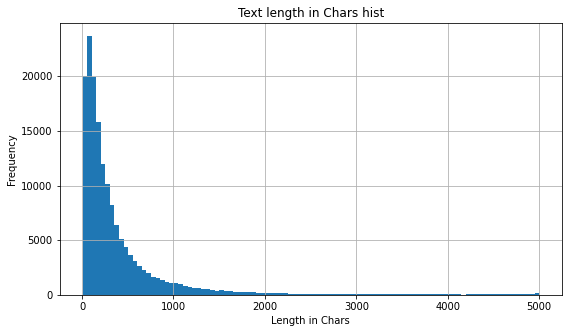

In [15]:
(
    data['text']
    .apply(lambda x: len(x))
    .plot(kind='hist', bins=100, figsize=(9,5), title = 'Text length in Chars hist', grid=True)
    .set_xlabel("Length in Chars")
);

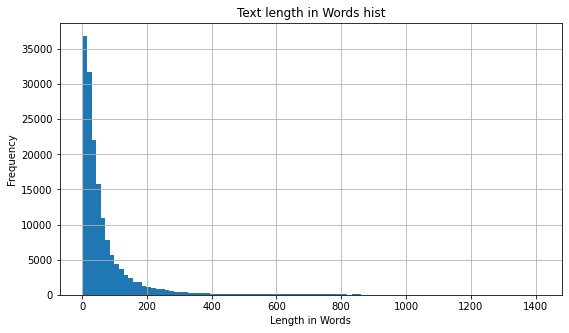

In [16]:
(
    data['text']
    .apply(lambda x: len(x.split()))
    .plot(kind='hist', bins=100, figsize=(9,5), title = 'Text length in Words hist', grid=True)
    .set_xlabel("Length in Words")
);

**Resume**
- Language is English
- There are about 160k rows total
- Most messages are short. We have a few messages with length more than 512 words

## Feature Engineering <a class="anchor" id="features"></a>
- Look at the long messages
- Type casting is not required
- Check missing values
- Check duplicates
- Search for anomalies
- Create an additional column with lemmatized text
- Create TF-IDF Features

### Basic preprocessing <a class="anchor" id="basic"></a>

In [17]:
df = data[data['text'].apply(lambda x: len(x.split())) > 512]  # тут надо было 512*<длина слова>
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 126 to 159204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1969 non-null   object
 1   toxic   1969 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.1+ KB


In [18]:
df.sample(1).iloc[0, 0]

'"\n\n Kickstart disks \n\nThe current article states \'subsequent Amiga models all used ROM chips\' [following the A1000] in relation to Kickstart.\n\nHowever, I remember that the Amiga 3000 also required such a Kickstart disk. Can anyone confirm? Thanks!\n\nMost A3000s used ROMs, but some (like mine) had a small ""Super Kickstart"" in ROM which read Kickstart from floppy or hard disk. (Super Kickstart was based on AmigaOS 1.4, which never appeared anywhere else.) IIRC, only the machines manufactured in Europe had ""Super Kickstart"", but I may well be wrong on that detail. I do know that I never got my machine to boot a v3.x AmigaOS =(. Cheers, (talk) \n\n Freeing memory \n\n(This is relevant to a different Wikipedia article). I have the statement in front of me that, when a program terminates in AmigaOS, memory assigned by the program is not freed, and that it is therefore vital for the program to release all memory that it asked for, otherwise it is permanently ""leaked"". Is this 

**Result**
- a little more than 1% of messages longer that 512 words
- selective viewing does not show unnecessary information (texts of forwarded messages, signatures, and so on)
- presumably the emotional coloring fits into the first 512 words, so we can limit the number of words when working with BERT.

In [19]:
df = data[data['text'].apply(lambda x: len(x)) < 20]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 899 to 159265
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    288 non-null    object
 1   toxic   288 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.8+ KB


In [20]:
df

,text,toxic
899,I've just seen that,0
1275,Is it still a stub?,0
2454,- unsigned comment,0
2499,I understand now.,0
2816,"Sure, goodnight! )",0
...,...,...
158822,"Yes, someone can. -",0
159169,Yeah i no it sucks.,1
159188,(talk • contribs),0
159193,You ignored him too,0


There are two rows with indices 119018 and 137400 that have the same text and different target. Most likely this is a markup error, we will delete them

In [21]:
print(data.shape)
data = data.drop([119018, 137400])
print(data.shape)

(159292, 2)
(159290, 2)


In [22]:
df = data[data['text'].apply(lambda x: len(x.split())) < 2]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 10193 to 141040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20 non-null     object
 1   toxic   20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


In [23]:
df.head(25)

,text,toxic
10193,"64.86.141.133""",0
15432,"Howdy!""",0
19772,(www.ebenefits.va.gov),0
38743,"88.104.31.21""",0
52336,"14:53,",0
52369,User_talk:Blackson#Religious_bias,0
53679,92.24.199.233|92.24.199.233]],0
55641,Complaints/Mistakes,0
64788,http://en.wikipedia.org/wiki/Wikipedia_talk:No...,0
75905,http://finance.yahoo.com/news/7-fascinating-nu...,0


There are some messages, for example: numbers and punctuation only, "User:Wipeouting", email, url, "{{unbloc" etc. Just delete it in this case

In [24]:
print(data.shape)
data = data.drop([ 10193,  19772,  38743,  52336,  52369,  53679,
             64788,  75905,  93421, 105468, 106701, 109794, 110102, 111246,
            117465, 127522, 129962, 141040])
print(data.shape)

(159290, 2)
(159272, 2)


### Preprocessing

In [25]:
def preprocess(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [26]:
%%time
data['text_clear'] = data['text'].apply(lambda x: preprocess(x))
data['text_clear'].head()

CPU times: user 14.4 s, sys: 251 ms, total: 14.7 s
Wall time: 15.1 s


0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text_clear, dtype: object

### Lemmatization

In [27]:
lemmanizer = spacy.load('en', disable=['parser', 'ner'])

In [28]:
%%time

data['text_lemm'] = (
    data['text_clear']
    #.head(100)
    .swifter
    .allow_dask_on_strings(enable=True)
    .apply(lambda x: ' '.join([token.lemma_ for token in lemmanizer(x)]))
)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 31 s, sys: 7.02 s, total: 38 s
Wall time: 5min 27s


In [29]:
data['text_lemm'].head()

0    explanation why the edit make under -PRON- use...
1    d aww -PRON- match this background colour i m ...
2    hey man i m really not try to edit war -PRON- ...
3    more i can t make any real suggestion on impro...
4    -PRON- sir be -PRON- hero any chance -PRON- re...
Name: text_lemm, dtype: object

### Implicit Duplicates <a class="anchor" id="duplicates"></a>

In [30]:
data['text'].duplicated().sum()

0

In [31]:
data['text_lemm'].duplicated().sum()

1289

In [32]:
data[['text_lemm', 'toxic']].duplicated().sum()

1259

Excellent! Preprocessing and lemmatization revealed 1232 duplicates<br>
But... not all of them are labeled the same.

In [33]:
s = data[data['text_lemm'].duplicated()]['text_lemm']
df = data.query('text_lemm in @s')
df.shape

(2037, 4)

Curiously, some rows occur even more than 2 times

In [34]:
df = df.groupby('text_lemm')['toxic'].agg(['min', 'max']).reset_index()
df = df[df['min'] != df['max']]
with pd.option_context('display.max_colwidth', 400):
    display(df.head(df.shape[0]))

,text_lemm,min,max
52,-PRON- be go to make sure -PRON- be expose drop -PRON- relation with anti american hate group -PRON- be go to make sure -PRON- be expose drop -PRON- relation with anti american hate group,0,1
61,-PRON- fail at life n t,0,1
74,-PRON- may check with the fascist who refuse to allow any criticism of kde to be list in fact the one criticism of kde that hasn t be delete be counter with a but window user like -PRON- argument -PRON- want npov that mean fact and fact mean accept the criticism as well i like kde but some of -PRON- be just be moron about not allow any criticism get over -PRON- fanboy self and deal with -PRON-,0,1
84,-PRON- serious mental illness and addiction this be the most contructive thing that can ever be contribute as -PRON- relate to -PRON- and -PRON- involvement here please stop and think about the depth of -PRON- sickness sit there with -PRON- face glue to -PRON- computer screen uncompensated day after day week after week for year tinker with the biography of people -PRON- don t even know who act...,0,1
109,ahhhh -PRON- always feel good to have the last word to get in the last word although i don t sign -PRON- edit -PRON- can see that from the sinbot that i be the person that start this discussion of format the table lol yes good to see that everybody have more or less agree upon a non descript colour format fair enough well than no colour format for heading jack merridew i see that -PRON- go and...,0,1
122,ankit fadia ankit fadia be not a white hat hacker -PRON- be a serial liar i be be very kind here i be a security professional by trade ankit fadia be rate by attendee of the def con hacker conference the large hacker conference in the world as charlatan of the year call ankit fadia an author of several book on the subject of ethical hacking be as factual as like call barack obama the president...,0,1
151,block mardyks excellent work there shii -PRON- can t have -PRON- kind get -PRON- to think about what the maya actually say about -PRON- own prophecy -PRON- insult -PRON- offend -PRON- and abuse -PRON- and -PRON- just have to be ethical and persistant block those mother fukker take out the entire santa fe public library system be a great preemptive strike also there may be other of -PRON- kind ...,0,1
237,guess what -PRON- retard,0,1
251,hello nawlin why do -PRON- like to deflower prepubescent girl do not -PRON- know that s a felony,0,1
256,hey be -PRON- kid -PRON- i be add info to this site to make -PRON- much more reliable -PRON- must be sick head to think i be remove thing no body ever dare to care about this article -PRON- be -PRON- who be try to give some life yo useriously must be out of -PRON- mind go right ahead and do as -PRON- wish i be jsut help and there be no more need of maintenance tag all be omplete accord to -PRO...,0,1


Probably, these 30 texts can have a double interpretation or are marked up with errors. There is no way to unambiguously specify the correct target for them. We will remove it completely so that there is no ambiguity. For duplicates with the same targets, we will remove only repetitions

In [35]:
print(data.shape)
s = df['text_lemm']
drop_index = data.query('text_lemm in @s').index
data = data.drop(index = drop_index)
print(data.shape)

(159272, 4)
(159201, 4)


In [36]:
print(data.shape)
data = data.drop_duplicates(subset='text_lemm')
print(data.shape)

(159201, 4)
(157953, 4)


In [37]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def make_tf_idf(series):
    count_tf_idf = TfidfVectorizer(stop_words=stop_words)
    corpus = series#.values.astype('U')
    tf_idf = count_tf_idf.fit_transform(corpus)
    return tf_idf, count_tf_idf.get_feature_names_out()

[nltk_data] Downloading package stopwords to /Users/dima/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Conclusions**
- a little more than 1% of messages have length more than 512 words
- selective viewing does not show unnecessary information (texts of forwarded messages, signatures, and so on)
- presumably the emotional coloring fits into the first 512 words, you can limit the number of words when working with BERT.
- processed short messages, some deleted
- carried out lemmantization
- prepared function for creating TF-IDF features

## Exploratory Data Analysis <a class="anchor" id="eda"></a>
Let's try to get as much knowledge as possible about the proposed texts:
- look to classes balance
- carry out TF-IDF analisis

###  Classes imbalance <a class="anchor" id="imbalance"></a>

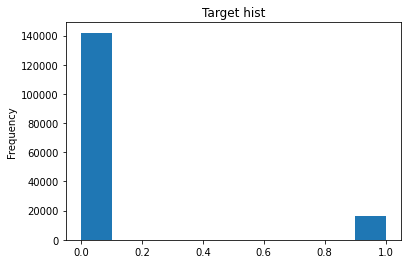

In [41]:
data['toxic'].plot(kind='hist', title='Target hist');

In [42]:
data['toxic'].value_counts(normalize=True)

0    0.898533
1    0.101467
Name: toxic, dtype: float64

**Resume** We have an imbalance of classes, we will use the F1 metric. If possible, take into account the imbalance of classes during modeling

### Frequency analysis <a class="anchor" id="freq"></a>

In [43]:
def tf_idf_analysis(series, exclude_list = []):
    tf_idf, names = make_tf_idf(series)
    M = np.mean(tf_idf, axis=0)
    tf_idf_mean = np.squeeze(np.asarray(M))
    tf_idf_df = pd.DataFrame()
    tf_idf_df['word'] = names
    tf_idf_df['value'] = tf_idf_mean
    tf_idf_df = tf_idf_df.query('word not in @exclude_list')
    return tf_idf_df

In [44]:
def make_counts(series):
    count_vect = CountVectorizer()
    corpus = series#.values.astype('U')
    bow = count_vect.fit_transform(corpus)
    return bow, count_vect.get_feature_names_out()

In [45]:
def counts_analysis(series, exclude_list = []):
    counts, names = make_counts(series)
    M = np.mean(counts, axis=0)
    counts_mean = np.squeeze(np.asarray(M))
    counts_df = pd.DataFrame()
    counts_df['word'] = names
    counts_df['value'] = counts_mean
    counts_df = counts_df.query('word not in @exclude_list')
    return counts_df

In [46]:
def make_analysis(func, title, exclude_list = ['pron'], words = 25, ax=None, samples=None):
    
    global data
    
    if (samples == None):
        samples = data.shape[0]
    
    df0 = (
        func(data[data['toxic'] == 0]['text_lemm'].head(samples), exclude_list = exclude_list)
            .sort_values(by='value', ascending=False)
            .head(words)
            .iloc[::-1]
            .set_index('word')
    )

    df1 = (
        func(data[data['toxic'] == 1]['text_lemm'].head(samples), exclude_list = exclude_list)
            .sort_values(by='value', ascending=False)
            .head(words)
            .iloc[::-1]
            .set_index('word')
    )

    df = df1.join(df0, how='outer', lsuffix='toxic', rsuffix='not_toxic')
    df.columns = ['Toxic', 'Not toxic']
    df['word'] = df.index
    df = df.sort_values(by='Toxic', ascending=False).iloc[::-1]
    df.plot(kind='barh', x='word', y=['Toxic', 'Not toxic'], title=title, ax=ax, color=['red', 'green']);

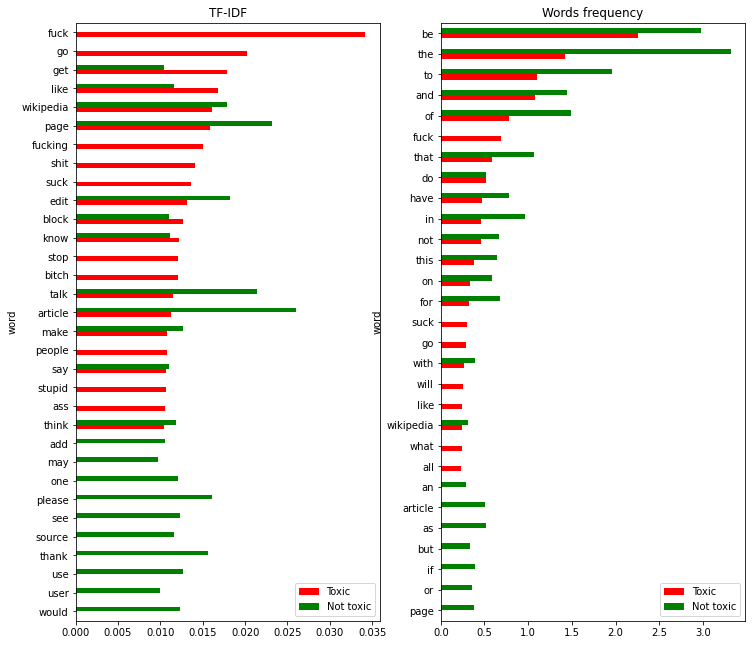

In [47]:
fig, axs = plt.subplots(1, 2, figsize = (12,11))

make_analysis(tf_idf_analysis, 'TF-IDF', ax=axs[0], words=22)
make_analysis(counts_analysis, 'Words frequency', ax=axs[1], words=22)

**Resume** There are differences in features. More significant differences have TF-IDF features at the first look. 

### Keywords discovery <a class="anchor" id="keywords"></a>

Let's find keywords for using in simple model

#### KeyBERT library <a class="anchor" id="keybert"></a>

In [48]:
model_name = 'unitary/toxic-bert'
hf_model = transformers.pipelines.pipeline("feature-extraction", model=model_name)
kw_model = KeyBERT(model=hf_model)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
def get_keywords(series, top_n=5):
    text = pd.Series(series.str.replace('-PRON-', '').str.cat(sep=' '))
    text = text.apply(lambda x: ' '.join(x.split()[:400]))
    return kw_model.extract_keywords(text, top_n=top_n)

In [54]:
%%time
kw_nontoxic = get_keywords(data[data['toxic']==0].sample(50, random_state=RANDOM_STATE)['text_lemm'], top_n=10)
kw_nontoxic

CPU times: user 10.8 s, sys: 1.26 s, total: 12 s
Wall time: 2min 11s


[('make', 0.9322),
 ('don', 0.9296),
 ('guy', 0.927),
 ('bikash', 0.9265),
 ('upper', 0.9243),
 ('ve', 0.9228),
 ('potentate', 0.922),
 ('let', 0.9209),
 ('turn', 0.9199),
 ('govern', 0.9196)]

In [55]:
kw_nontoxic = [x[0] for x in kw_nontoxic]

In [58]:
%%time
kw_toxic = get_keywords(data[data['toxic']==1].sample(100, random_state=RANDOM_STATE)['text_lemm'], top_n=30)
kw_toxic

CPU times: user 9.58 s, sys: 616 ms, total: 10.2 s
Wall time: 1min 58s


[('nigger', 0.6521),
 ('dildo', 0.5821),
 ('cunt', 0.5165),
 ('homosexual', 0.495),
 ('gay', 0.4724),
 ('vagoo', 0.4696),
 ('fat', 0.4336),
 ('suck', 0.4315),
 ('jerk', 0.4241),
 ('ass', 0.4228),
 ('pussy', 0.4167),
 ('rectum', 0.4159),
 ('stupidity', 0.4158),
 ('shitty', 0.4125),
 ('bullshit', 0.4006),
 ('cock', 0.393),
 ('shit', 0.3862),
 ('fucker', 0.3858),
 ('fucking', 0.3798),
 ('rot', 0.3793),
 ('ponos', 0.3733),
 ('fuck', 0.3715),
 ('wanker', 0.3009),
 ('pow', 0.2496),
 ('troll', 0.2487),
 ('loser', 0.2396),
 ('starve', 0.2279),
 ('penetrate', 0.2107),
 ('drunk', 0.198),
 ('piece', 0.1803)]

In [59]:
kw_toxic = [x[0] for x in kw_toxic]

**Resume** No so good. Slow

#### Simple keywords extraction using TF-IDF

In [60]:
key_words_simple = ['fuck', 'shit', 'fucking', 'suck', 'bitch', 'stupid', 'ass']

#### Using open source

In [61]:
# https://en.wiktionary.org/wiki/Category:English_swear_words
swear_words = ['arse', 'arsehead', 'arsehole', 'ass', 'asshole', 
              'bastard', 'bitch', 'bloody', 'bollocks', 'brotherfucker', 'bugger', 'bullshit', 
              'child-fucker', 'cock', 'cocksucker', 'crap', 'cunt', 
              'damn', 'dick', 'dickhead', 'dyke',
              'fatherfucker', 'frigger', 'fuck', 'fucking',
              'goddamn', 'godsdamn', 'hell', 'horseshit', 'kike', 'motherfucker', 
              'nigga', 'nigra', 'piss', 'prick', 'pussy', 'shit', 'shite',
              'sisterfucker', 'slut', 'spastic', 'twat', 'wanker']

#### Create custom analysis <a class="anchor" id="custom"></a>

Let's conduct **our own analysis** of keywords (we will prepare in a general form for more than one class):
- for each class for all words we find:
     - frequency of use *within* the class
     - frequency of use *outside* class
     - *ratio* of frequency inside *class* and *out* of class
- now for each class we sort the words by *relative* frequencies, exclude from the list, sort in descending order, look and take the TOP-N
- as a result, we get for each class a list of words specific to this class
- two modifications can be made
     - frequency of words in the corpus
     - the number of texts in the corpus with a given word

As a result, we already have the sets `kw_nontoxic`, `kw_toxic`, `key_words_simple`, `swear_words` and plus two more from this algorithm. Then we get 2^N-1 combinations of keyword sets, which we combine into one and will be used in the keyword model. 

In [62]:
def make_freq_dict(series, count_type):
    """Returns a dictionary where the keys are words and the values are the frequency in the text"""

    counts, names = make_counts(series)
    
    if count_type == 'word':
        M = np.sum(counts, axis=0)
    elif count_type == 'text':
        M = np.sum(counts.astype(bool), axis=0)
        
    freqs = np.squeeze(np.asarray(M)) / series.shape[0]
    
    ret = {}
    for i in range(len(names)):
        if (freqs[i] > 0):
            ret[names[i]] = freqs[i]
            
    return ret

def kw_process(df, target, target_column, text_column, n_max=50, n_min=10, min_weight=50, count_type='word'):
    """ 
    Discover class specific keywords
        (in cases of binary classification, it can be accelerated by swapping inside and outside for the second class)
    
    Parameters:
        df - DataFrame
        target - target value
        target_column - target column
        text_column - column with lemmatized text
        n_max - max count of keywords returned by function
        n_min - min count of keywords returned by function (if possible)
        min_weight - min weight of keyword
        count_type = ['word', 'text'] - function count the number of words or the number of texts with a word
        
    Return (kw_list, kw_weight)
        kw_list - list of keyword ordered by relevant descending
        kw_weight - list of weightss
        """
    
    # get frequency dictionaries inside the class and outside the class
    inside = make_freq_dict(df[df[target_column] == target][text_column], count_type)
    outside = make_freq_dict(df[df[target_column] != target][text_column], count_type)
    names = [x for x in inside.keys()]

    # get words rating
    mf = min([x for x in outside.values()]) # защита от деления на ноль
    ratio = [inside[w]/(outside.get(w, 0)+mf) for w in inside]
    
    # sorting
    sorter = np.argsort(ratio)[::-1]
    
    # update returned word's count variables
    for i in range(n_max)[::-1]:
        if ratio[sorter[i]] < min_weight:
            n_max = i
    if n_max < n_min:
        n_max = n_min
    if n_max > len(ratio):
        n_max = len(ratio)
        
    # get result lists
    kw_list = [names[sorter[i]] for i in range(n_max)] 
    kw_weight = [ratio[sorter[i]] for i in range(n_max)] 
            
    return (kw_list, kw_weight)

In [63]:
%%time
kw_list, kw_weight = kw_process(data, target=1, 
                               target_column='toxic', text_column='text_lemm', 
                               n_max=50)
kw_list

CPU times: user 9.38 s, sys: 390 ms, total: 9.77 s
Wall time: 10 s


['fucksex',
 'yourselfgo',
 'cocksucker',
 'buttsecks',
 'mothjer',
 'fggt',
 'bastere',
 'boobs',
 'offfuck',
 'niggas',
 'bitches',
 'sexsex',
 'notrhbysouthbanof',
 'criminalwar',
 'bunksteve',
 'marcolfuck',
 'fack',
 'noobs',
 'securityfuck',
 'cuntbag',
 'youbollock',
 'ancestryfuck',
 'cocksucke',
 'licker',
 'nhrhs',
 'motherfucker',
 'fuckin',
 'shitfuck',
 'faggot',
 'centraliststupid',
 'fucker',
 'supertr',
 'bleachanhero',
 'aidsaids',
 'bitchmattythewhite',
 'yaaaa',
 'haahhahahah',
 'biznitch',
 'chocobos',
 'dickhead',
 'cuntliz',
 'chula',
 'veggietale',
 'phuq',
 'pensnsnniensnsn',
 'pennnis',
 'pneis',
 'uuuuuu',
 'itsuck',
 'kkkkkk']

In [64]:
%%time
kw_list, kw_weight = kw_process(data, target=0, 
                               target_column='toxic', text_column='text_lemm', 
                               n_max=50, n_min=10, min_weight=100)
kw_list

CPU times: user 9.76 s, sys: 395 ms, total: 10.2 s
Wall time: 10.6 s


['tacos',
 'fffa',
 'specify',
 'newsletter',
 'philippineslong',
 'cellpadding',
 'nikko',
 'tutorial',
 'deneid',
 'vertical']

**Resume by keyword search algorithm:**
- It got a lot better) Toxic words are chosen.
- And it works fast
- Curiously, there are no keywords in normal speech (10 words are derived exclusively from the `n_min=10` parameter). Their weight is significant less compared to toxic.
- Actually, the best result for keywords was given by the analysis of the weights of the trained linear regression by frequency features

### Text length <a class="anchor" id="len"></a>
Compare the mean words count in the classes

In [65]:
data['word_count'] = data['text_lemm'].apply(lambda x: len(str(x).split()))
print(data[data['toxic']==1]['word_count'].mean())
print(data[data['toxic']==0]['word_count'].mean())

54.27328882510763
69.86441525865592


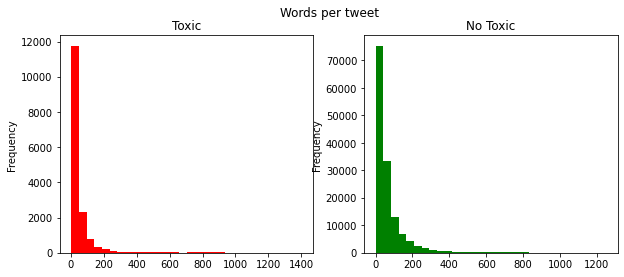

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

data[data['toxic']==1]['word_count'].plot(kind='hist', bins=30, color='red', ax=ax1, title='Toxic')
data[data['toxic']==0]['word_count'].plot(kind='hist', bins=30, color='green', ax=ax2, title='No Toxic')

fig.suptitle('Words per tweet')
plt.show()

In [67]:
data['char_count'] = data['text'].apply(lambda x: len(str(x)))
print(data[data['toxic']==1]['char_count'].mean())
print(data[data['toxic']==0]['char_count'].mean())

303.02383477881074
404.8283119372067


**Resume** The distribution of the number of words in the texts is similar. Non-toxic texts are longer, logical.

### EDA Conclusions
- there is a class imbalance
- there is a class difference in TF-IDF
- there is a class difference in word frequencies
- visually the difference between ghosts in TF-IDF is more significant
- prepared lists of keywords in different ways
- prepared an algorithm for identifying class-specific keywords
- non-toxic messages are on average longer (differences are not significant enough to be used as a feature)

## Modeling <a class="anchor" id="model"></a>

We will try several approach:
- baseline based on keywords
- logistic regression based frequency features
- RF, LGBT, XGB...
- BERT as embedding
- Universal Sentence Encoder as embending
- BERT with fine tuning (learning)
- specific BERT model as embending
- ensamble

### Struggle with imbalance <a class="anchor" id="model-imbalance"></a>

We have imbalance in target classed. Only 10% of texts is tixoc.

Strategies:
- Split with stratification by target class
- Syntetic generation  https://rikunert.com/SMOTE_explained (we didn't use in this case)
- Undersampling
- Oversampling
- Use class weightes

### Train-Test Split

- Train (60%)
- Validation (20%)
- Test (20%)

We don't use CV because heavy models will be trained too long and light models wouldn't in leaders anyway.

In [10]:
# save dataset to moving to GPU server
try:
    data.to_csv('data_toxic_comments.csv')
except:
    pass

In [81]:
data_f = data.drop(columns=['toxic'])
data_t = data['toxic']

train_valid_f, test_f, train_valid_t, test_t = train_test_split(data_f, data_t, 
                                                  train_size=0.80, random_state=random_state, stratify=data_t)
train_f, valid_f, train_t, valid_t = train_test_split(train_valid_f, train_valid_t, 
                                                    train_size=0.75, random_state=random_state, stratify=train_valid_t)

print('train_f shape = ', train_f.shape)
print('train_t shape = ', train_t.shape)
print('valid_f shape = ', valid_f.shape)
print('valid_t shape = ', valid_t.shape)
print('test_f shape = ', test_f.shape)
print('test_t shape = ', test_t.shape)

train_f shape =  (94771, 5)
train_t shape =  (94771,)
valid_f shape =  (31591, 5)
valid_t shape =  (31591,)
test_f shape =  (31591, 5)
test_t shape =  (31591,)


In [82]:
def eval_model(model, df_f, df_t):
    predict = model.predict(df_f)
    print(classification_report(df_t, predict))
    return f1_score(df_t, predict)
    
def train_model(model, train_f=train_f, train_t=train_t, valid_f=valid_f, valid_t=valid_t):
    model.fit(train_f, train_t)
    f1_valid = eval_model(model, valid_f, valid_t)
    print('f1 valid =', f1_valid)
    return (model, f1_valid)

In [83]:
stat = {}

In [84]:
class DummyModel():
    def __init__(self, strategy='prior'):
        self.dummy = DummyClassifier(strategy=strategy)
        
    def fit(self, df_f, df_t):
        self.dummy.fit(df_f, df_t)
        
    def predict(self, df_f):
        return self.dummy.predict(df_f)

In [85]:
res = train_model(DummyModel(strategy='uniform'))

              precision    recall  f1-score   support

           0       0.90      0.51      0.65     28385
           1       0.10      0.49      0.17      3206

    accuracy                           0.50     31591
   macro avg       0.50      0.50      0.41     31591
weighted avg       0.82      0.50      0.60     31591

f1 valid = 0.16806544141081484


In [86]:
stat['Dummy'] = res

### Model based on keywords <a class="anchor" id="model-keywords"></a>
We have few keywords sets: `kw_nontoxic`, `kw_toxic`, `key_words_simple`, `swear_words` and two from algorithm. For each keyword we make feature that indicate thare is this keyword in text or no. And then fit linear regression

In [87]:
class KwModel():
    def __init__(self, auto=True, additional_keywords=[],
                 n_max=50, n_min=10, min_weight=100, max_iter=5000, count_type='word'):
        """
        How to generate keywords:
            auto - autimatically creation of keywords
            n_max - maximum count of keywords
            n_max - minimal count of keywords
            min_weight - minimal keyword weight
            count_type = ['word', 'text'] - count words or texts
        """
        self.auto = auto
        self.additional_keywords = additional_keywords
        self.n_max = n_max
        self.n_min = n_min
        self.min_weight = min_weight
        self.max_iter = max_iter
        self.count_type = count_type
        
        self.text_column = 'text_lemm'
        self.target_column = 'toxic'
        
    def make_features(self, df):
        cache = df[self.text_column].apply(lambda x: x.split())
        for kw in self.kw_set:
            df[kw] = cache.apply(lambda x: kw in x)
        return df.drop(columns=[self.text_column], errors='ignore')
        
    def fit(self, df_f, df_t):
        df_f = df_f[[self.text_column]].copy()
        
        self.kw_set = self.additional_keywords
        if self.auto:
            for y in df_t.unique():
                kw, _ = kw_process(df_f.join(df_t), target=y, 
                                   target_column=self.target_column, text_column=self.text_column, 
                                   n_max=(self.n_max if type(self.n_max) == int else self.n_max[y]), 
                                   n_min=(self.n_min if type(self.n_min) == int else self.n_min[y]), 
                                   min_weight=(self.min_weight if type(self.min_weight) == int else self.min_weight[y]),
                                   count_type=(self.count_type if type(self.count_type) == str else self.count_type[y]))
                self.kw_set = self.kw_set + kw
                
        df_f = self.make_features(df_f)
        
        self.model = LogisticRegression(max_iter=self.max_iter, class_weight='balanced')
        self.model.fit(df_f, df_t)
        
    def predict(self, df_f):
        df_f = df_f[['text_lemm']].copy()
        df_f = self.make_features(df_f)
        return self.model.predict(df_f)

In [88]:
%%time

# n_max=..., n_min=..., min_weight=..., max_iter=...
# keywords: auto, kw_nontoxic, kw_toxic, key_words_simple, swear_words
# count_type = ['word', 'text']
#res = train_model(KwModel(n_max=150, n_min=10))
res = train_model(KwModel(n_max=500, n_min=5, min_weight=5, count_type='text'))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28385
           1       0.82      0.63      0.71      3206

    accuracy                           0.95     31591
   macro avg       0.89      0.81      0.84     31591
weighted avg       0.95      0.95      0.95     31591

f1 valid = 0.7125420130903944
CPU times: user 3min 52s, sys: 4.51 s, total: 3min 57s
Wall time: 3min 19s


In [89]:
stat['KW'] = res

**Resume**
- Automatically keyword generation allow to build algorithm with f1=0.71
- Keywords sets reting:
    - **0.05** `kw_nontoxic` + `kw_toxic` - very low!
    - **0.56** `key_words_simple` - just few words that we select based on plots!
    - **0.57** `swear_words` - not bad because set downloaded without any analytics
    - **0.60** `kw_nontoxic` + `kw_toxic` + `key_words_simple` + `swear_words` 
    - **0.71** `auto` - the best
    - **0.71** `auto` + `kw_nontoxic` + `kw_toxic` + `key_words_simple` + `swear_words`
- Keywords count more that 500 don't increase metric

### Logistic regression base frequency features <a class="anchor" id="lr"></a>
- count vectorizer
- tf-idf vectorizer

In [90]:
class CountModel():

    def fit(self, df_f, df_t):
        self.vect = CountVectorizer() # ngram_range=(1, 2), min_df=0.0001, stop_words=stop_words
        self.model = LogisticRegression(max_iter=5000, class_weight='balanced')
        self.pipe = ib.pipeline.Pipeline([
            ('vect', self.vect), 
            #('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
            #('sam', RandomOverSampler(random_state=random_state)),
            #('sam', RandomUnderSampler(random_state=random_state)),
            ('model', self.model)
        ])
        
        self.pipe.fit(df_f['text_lemm'], df_t)
        
    def get_model(self):
        return self.vect, self.model
        
    def predict_proba(self, df_f):
        return self.pipe.predict_proba(df_f['text_lemm'])[:,1]
    
    def predict(self, df_f):
        return [1 if y > 0.65 else 0 for y in self.pipe.predict_proba(df_f['text_lemm'])[:,1]]

In [91]:
%%time
res = train_model(CountModel())

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     28385
           1       0.77      0.78      0.78      3206

    accuracy                           0.95     31591
   macro avg       0.87      0.88      0.88     31591
weighted avg       0.95      0.95      0.95     31591

f1 valid = 0.777121541809139
CPU times: user 4min 3s, sys: 1min 8s, total: 5min 12s
Wall time: 51.7 s


In [92]:
stat['Counts'] = res

In [93]:
vect, model = res[0].get_model()
names = vect.get_feature_names_out()
weights = model.coef_

n = 30
weights = abs(weights[0])
ind = np.argpartition(weights, -n)[-n:] # алгоритм линейной сложности поиска top n без сортировки
ind = ind[np.argsort(weights[ind])][::-1] # сортировка по убыванию

# print(weights[0][ind])
print(names[ind])

['fuck' 'faggot' 'fucking' 'shit' 'idiot' 'bitch' 'asshole' 'bullshit'
 'ass' 'cunt' 'suck' 'stupid' 'bastard' 'idiotic' 'moron' 'dick' 'penis'
 'dumbass' 'motherfucker' 'fucker' 'pussy' 'nigger' 'crap' 'dickhead'
 'fuckhead' 'retard' 'fag' 'jackass' 'jerk' 'wtf']


**Resume:** 
- Count vectorizer plus LR has F1 = **0.77**, good
- TF-IDF vectorizer plus LR has F1 = **0.74**
- The best method extract keywords is interpritation of weightes of fitted logistic regression

### RF, LGBT, XGB... <a class="anchor" id="boost"></a>
We don't expect good quality of trees algorithms in this case

In [11]:
class LGBTModel():

    def fit(self, df_f, df_t):
        
        # ngram_range=(1, 2), min_df=0.0001, stop_words=stop_words
        #self.vect = CountVectorizer();
        self.vect = TfidfVectorizer();
        X = self.vect.fit_transform(df_f['text_lemm'])
        
        self.model = lgb.LGBMClassifier(n_estimators=500, random_state=random_state)
        
        self.model.fit(X.astype(float), df_t)
        
    def get_model(self):
        return self.vect, self.model
        
    def predict_proba(self, df_f):
        X = self.vect.transform(df_f['text_lemm'])
        return self.model.predict(X.astype(float))
    
    def predict(self, df_f):
        X = self.vect.transform(df_f['text_lemm'])
        return self.model.predict(X.astype(float))

In [95]:
%%time
res = train_model(LGBTModel())

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28385
           1       0.88      0.69      0.78      3206

    accuracy                           0.96     31591
   macro avg       0.92      0.84      0.88     31591
weighted avg       0.96      0.96      0.96     31591

f1 valid = 0.7755815987405983
CPU times: user 5min 37s, sys: 11.4 s, total: 5min 49s
Wall time: 53.3 s


In [96]:
stat['LGBT'] = res

Significance analysis

In [97]:
try:
    import shap
except:
    pass

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


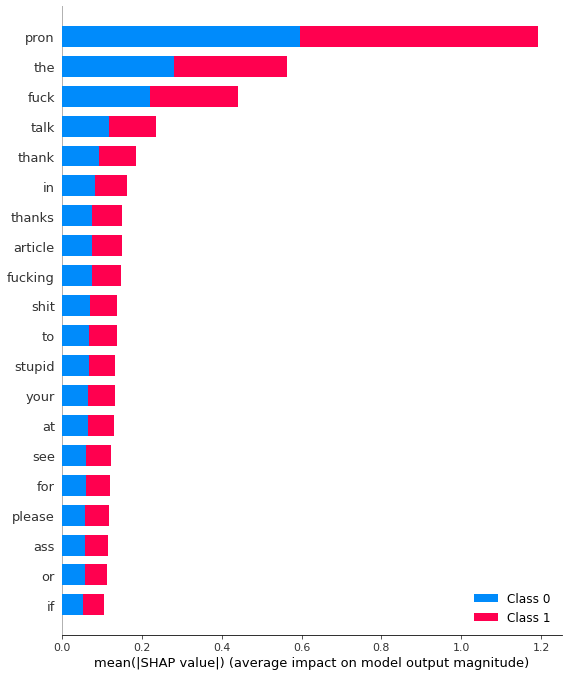

In [98]:
try:
    vect, model = res[0].get_model()
    explainer = shap.Explainer(model)
    inputs = vect.transform(valid_f.sample(1000)['text']).toarray()
    shap_values = explainer.shap_values(inputs)
    shap.summary_plot(shap_values, inputs, feature_names = vect.get_feature_names_out())
except:
    pass

**Resume:**
- Count vectorizer is more situable than TF-IDF in this case
- Significance analysis doen't extract keywords well

### CatBoost <a class="anchor" id="catboost"></a>

In [99]:
class CatBoostModel():
    def fit(self, df_f, df_t, valid_f, valid_t):
        
        train_pool = Pool(data=df_f[['text']], label=df_t, text_features=['text'])
        valid_pool = Pool(data=valid_f[['text']], label=valid_t, text_features=['text'])
        
        # gyper parameters are also selected
        self.model = CatBoostClassifier(
            task_type='GPU', iterations=5000, eval_metric='F1', od_type='Iter', od_wait=500,
            tokenizers=[
                {
                    'tokenizer_id': 'Sense',
                    'separator_type': 'BySense',
                    'lowercasing': 'True',
                    'token_types':['Word', 'Number', 'SentenceBreak'],
                    'sub_tokens_policy':'SeveralTokens'
                }      
            ],
            dictionaries = [
                {
                    'dictionary_id': 'Word',
                    'max_dictionary_size': '50000'
                }
            ],
            feature_calcers = [
                'BoW:top_tokens_count=10000'
            ]
        )
        
        self.model.fit(train_pool, eval_set=valid_pool, verbose=100, plot=True, use_best_model=True)

    def get_model(self):
        return self.model
    
    def predict(self, df_f):
        return self.model.predict(df_f[['text']])

The model has been trained and tested on GPU server. The result has been saved to final table below

In [100]:
stat['CatBoost'] = (None, 0.7586206896551724)

**Resume:** 
- the result isn't the best, may be needed to turn gyper paramenters
- CatBoost trained very fast on GPU, only 47 secs
- CatBoost is usefull to work with combination numeric, categorized and text features

### BERT Embedding <a class="anchor" id="bertemb"></a>

We prepare BERT embeddings in Colab on GPU environment

In [101]:
train_f.to_csv('temp/train_f.csv')
train_t.to_csv('temp/train_t.csv')
valid_f.to_csv('temp/valid_f.csv')
valid_t.to_csv('temp/valid_t.csv')
test_f.to_csv('temp/test_f.csv')
test_t.to_csv('temp/test_t.csv')

' Этот код выполнялся локально (нужен доступ к диску)'

In [102]:
def generate_emb(df, bert_name='bert-base-cased'):
    """The function add 768 columns of bert-embeddings to the DataFrame df"""
    
    tokenizer = transformers.BertTokenizer.from_pretrained(bert_name)
    bert = transformers.BertModel.from_pretrained(bert_name)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        bert = bert.cuda()
    
    features = []
    for text in notebook.tqdm(df['text']):
        token = tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
        input_id = token['input_ids'].squeeze(1).to(device)
        mask = token['attention_mask'].to(device)
        output = bert(input_id, mask)
        features.append(output.last_hidden_state[0,0,:].cpu().detach().numpy())

    pd.DataFrame(features)
    df = df.reset_index(drop=True).join(pd.DataFrame(features))
    return df

In [103]:
""" executed in CoLab """
# %%time
# for fn in ['train_f', 'valid_f', 'test_f']:
#     df = pd.read_csv(f'/content/gdrive/MyDrive/Colab Notebooks/yandex-bert/{fn}.csv')
#     df_e = generate_emb(df)
#     df_e.to_csv(f'/content/gdrive/MyDrive/Colab Notebooks/yandex-bert/{fn}_e.csv')

' Этот код выполнялся в CoLab '

![jupyter](./colab-1.png)

In [104]:
# train_f_e = pd.read_csv('temp/train_f_e2.csv')
# valid_f_e = pd.read_csv('temp/valid_f_e2.csv')
# test_f_e = pd.read_csv('temp/test_f_e2.csv')

# print(train_f_e.shape)
# train_f_e.head(2)

' Этот код выполнялся локально (нужен доступ к диску)'

DataFrame with embenddings:
![jupyter](./local-1.png)

In [105]:
class BertEmbModel():

    def fit(self, df_f, df_t):
        #self.model = ib.pipeline.Pipeline([
        #    #('sam', RandomOverSampler(random_state=random_state)),
        #    #('sam', RandomUnderSampler(random_state=random_state)),
        #    ('model', LogisticRegression(max_iter=5000, class_weight='balanced'))
        #    #('model', RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8))
        #    ])
        #self.model = lgb.LGBMClassifier(random_state=random_state)
        
        neg, pos = np.bincount(df_t)
        total = neg + pos

        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.Dense(768, input_shape=(768,), activation='linear'),
            #tf.keras.layers.Dense(100, activation='linear'),
            tf.keras.layers.Dense(1, activation='sigmoid')
          ])        

        self.model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
        
        self.model.fit(df_f[[str(x) for x in range(768)]], df_t.values, epochs=5,
                      validation_data=(valid_f_e[[str(x) for x in range(768)]], valid_t.values),
                      #class_weight=class_weight
                      )
        
    def predict(self, df_f):
        df = df_f[[str(x) for x in range(768)]]
        return [1 if y > 0.35 else 0 for y in self.model.predict(df)]

In [106]:
train_f_e = pd.read_csv('temp/train_f_e2.csv')
valid_f_e = pd.read_csv('temp/valid_f_e2.csv')
res = train_model(BertEmbModel(), train_f=train_f_e, valid_f=valid_f_e)

' Этот код выполнялся локально '

The results:

f1 valid = 0.701948051948052<br>
Wall time: 49.8 s

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     28385
           1       0.73      0.67      0.70      3206


In [107]:
stat['BERT-emb'] = (None, 0.701948051948052)

Let's try use toxic-specific bert model

In [108]:
# 'unitary/toxic-bert'
class BertTxicEmbModel():

    def fit(self, df_f, df_t):
        # self.model = ib.pipeline.Pipeline([
        #     #('sam', RandomOverSampler(random_state=random_state)),
        #     #('sam', RandomUnderSampler(random_state=random_state)),
        #     ('model', LogisticRegression(max_iter=5000, class_weight='balanced'))
        #     #('model', RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=8))
        #     ])
        # #self.model = lgb.LGBMClassifier(random_state=random_state)
        # self.model.fit(df_f[[str(x) for x in range(768)]], df_t)
        
        neg, pos = np.bincount(df_t)
        total = neg + pos

        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(768, input_shape=(768,), activation='linear'),
            #tf.keras.layers.Dense(100, activation='linear'),
            tf.keras.layers.Dense(1, activation='sigmoid')
          ])        

        self.model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
        
        self.model.fit(df_f[[str(x) for x in range(768)]], df_t.values, epochs=3,
                      validation_data=(valid_f_e_toxic[[str(x) for x in range(768)]], valid_t.values),
                      #class_weight=class_weight
                      )
        
    def predict(self, df_f):
        # return self.predict(df_f[[str(x) for x in range(768)]])
        df = df_f[[str(x) for x in range(768)]]
        return [1 if y > 0.5 else 0 for y in self.model.predict(df)]

In [13]:
train_f_e_toxic = pd.read_csv('temp/train_f_e_toxic.csv')
valid_f_e_toxic = pd.read_csv('temp/valid_f_e_toxic.csv')
res = train_model(BertTxicEmbModel(), train_f=train_f_e_toxic, valid_f=valid_f_e_toxic)

' Этот код выполнялся локально '

In [110]:
stat['BERT-toxic-emb'] = (None, 0.946)

**Resume** 
- Pre-trained at specific domain bert model is greater solution

### TNSE embedding visualization <a class="anchor" id="tnse"></a>

In [111]:
from sklearn.manifold import TSNE
import plotly.express as px

In [112]:
def tsne_plot(df_f, df_t, y_range = [8,13]):
    sam = RandomUnderSampler(sampling_strategy={0: 1000, 1: 1000}, random_state=random_state)
    mini_f_e, mini_t = sam.fit_resample(df_f, df_t)
    
    X = list(mini_f_e[[str(x) for x in range(768)]].to_numpy())
    X_embedded = TSNE(n_components=2).fit_transform(X)
    
    df_embeddings = pd.DataFrame(X_embedded)
    df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
    df_embeddings = df_embeddings.assign(label=mini_t.apply(lambda x: str(x)).values)
    df_embeddings = df_embeddings.assign(text=mini_f_e['text'].values)
    
    fig = px.scatter(
        df_embeddings, x='x', y='y',
        color='label', #labels={'color': 'label'},
        title = 'Embedding Visualization', width=800, height=600)
    fig.update_yaxes(range = y_range)
    fig.show()

In [113]:
print('bert-base-cased')
tsne_plot(valid_f_e, valid_t)

'Этот код выполнялся локально'

![jupyter](./tnse-1.png)

In [114]:
print('unitary/toxic-bert')
tsne_plot(valid_f_e_toxic, valid_t)

'Этот код выполнялся локально'

![jupyter](./tnse-2.png)

**Resume**
- TSNE allows to vizualize embeddings
- There is a clear difference between the two models. And on BERT-toxic it is clearly visible that toxic texts can be clustered into 4 separate clusters

### Universal Sentence Encoder <a class="anchor" id="use"></a>
There is alternative model for generation embeddings

In [115]:
class UseEmbModel():

    def fit(self, df_f, df_t):
        self.embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        embendings = [x.numpy() for x in self.embed(df_f['text'])]
        
        neg, pos = np.bincount(df_t)
        total = neg + pos

        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weight = {0: weight_for_0, 1: weight_for_1}
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(512, input_shape=(512,), activation='linear'),
            tf.keras.layers.Dense(100, activation='linear'),
            tf.keras.layers.Dense(1, activation='sigmoid')
          ])

        self.model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
        
        self.model.fit(pd.DataFrame(embendings), df_t.values, epochs=2,
                      #validation_data=(valid_f_use, valid_t.values),
                      #class_weight=class_weight
                      )
        
    def predict_proba(self, df_f):
        return self.model.predict(df_f)
        
    def predict(self, df_f):
        embendings = [x.numpy() for x in self.embed(df_f['text'])]
        return [1 if y > 0.5 else 0 for y in self.model.predict(pd.DataFrame(embendings))]

In [116]:
%%time
res = train_model(UseEmbModel())

In [117]:
stat['USE-emb'] = (None, 0.71)

**Resume**
- The time of generation of embedding is significatn lower that bert (5ms vs 0.6sec on CPU). It's a plus/
- The result is simular to bert
- As the name suggests, this network is good to use in chatbots when comparing questions

### BERT with fine tuning <a class="anchor" id="bert-fine"></a>

The idea is the following:
- create our own class inherited from torch.Module, take the BERT model, override the forward method
- in the forward method, we pass the input vector through bert, and the output bert through our own additional layers
- this way we get a model consisting of bert and our layers, which can be trained as a whole
- train the model

Such training is resource intensive. Of course, we will run it on a Colab with a GPU, but it's still a long time (Colab cannot be left to count overnight). We are interested in how much the retrained model will be better than other architectures from this project. Let's shorten the time like this:
- we will perform Under-Sampling for the training data and additionally save the resulting dataset (the total size of the training sample was 13000 rows)
- we will train interesting models on it, save separate statistics and look at the results
- it is clear that on incomplete data the quality will be worse than if trained on a full training set

In [15]:
# mini training set
sam = RandomUnderSampler(sampling_strategy={0: 8000, 1: 5000}, random_state=random_state)
train_mini_f, train_mini_t = sam.fit_resample(train_f, train_t)

Yandex Data Shere results
- The time of training 4 epohes each contained 13000 rows on **GPU V100** was about 40 minutes
- The result is **f1=0.7572715572715573** on our validate set

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     28385
           1       0.64      0.92      0.76      3206



In [119]:
ministat = {'BERT+': 0.7572715572715573}

Now let's run the rest of the model types and store the results in `ministat`. We will assume that on a smaller sample, the optimal hyperparameters do not differ too much from those already tuned and we will not tune them again

In [120]:
train_mini_f_e = pd.read_csv('temp/train_mini_f_e2.csv')
res = train_model(BertEmbModel(), train_f=train_mini_f_e, train_t=train_mini_t, valid_f=valid_f_e)
res = train_model(UseEmbModel(), train_f=train_mini_f, train_t=train_mini_t)

' Этот код выполнялся локально '

In [121]:
ministat['BERT-emb'] = 0.6285388127853881
ministat['USE-emb'] = 0.6681161273820181

In [122]:
res = train_model(LGBTModel(), train_f=train_mini_f, train_t=train_mini_t)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     28385
           1       0.63      0.82      0.72      3206

    accuracy                           0.93     31591
   macro avg       0.81      0.88      0.84     31591
weighted avg       0.94      0.93      0.94     31591

f1 valid = 0.7161666892900773


In [123]:
ministat['LGBT'] = res[1]

In [124]:
res = train_model(CountModel(), train_f=train_mini_f, train_t=train_mini_t)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28385
           1       0.68      0.79      0.73      3206

    accuracy                           0.94     31591
   macro avg       0.83      0.88      0.85     31591
weighted avg       0.95      0.94      0.94     31591

f1 valid = 0.7301405219386291


In [125]:
ministat['Count'] = res[1]

In [126]:
res = train_model(KwModel(n_max=500, n_min=5, min_weight=5, count_type='text'),
                 train_f=train_mini_f, train_t=train_mini_t)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     28385
           1       0.67      0.79      0.72      3206

    accuracy                           0.94     31591
   macro avg       0.82      0.87      0.84     31591
weighted avg       0.94      0.94      0.94     31591

f1 valid = 0.7233859397417503


In [127]:
ministat['KW'] = res[1]

In [128]:
ministat

{'BERT+': 0.7572715572715573,
 'BERT-emb': 0.6285388127853881,
 'USE-emb': 0.6681161273820181,
 'LGBT': 0.7161666892900773,
 'Count': 0.7301405219386291,
 'KW': 0.7233859397417503}

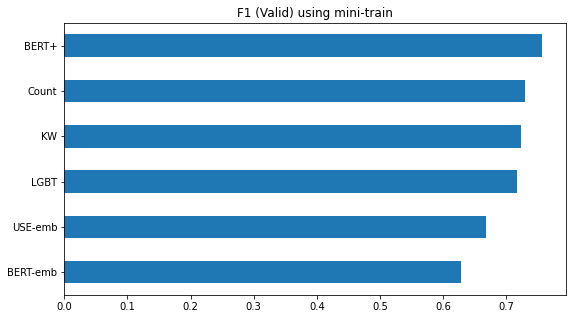

In [129]:
(
    pd.DataFrame(ministat, index=['f1'])
        .transpose()
        .sort_values('f1')
        .plot(kind='barh', legend=False, figsize=(9,5), title='F1 (Valid) using mini-train')
);

**Resume**
- the retrained model is much better than the related emboding, but it requires a long/expensive training
- compared to the full sample, the results are distributed somewhat differently, most likely the embeddings did not have enough data to train on the same number of epochs. But comparing BERT-emb and BERT+ is quite legal.

### Ensambling <a class="anchor" id="ensambling"></a>

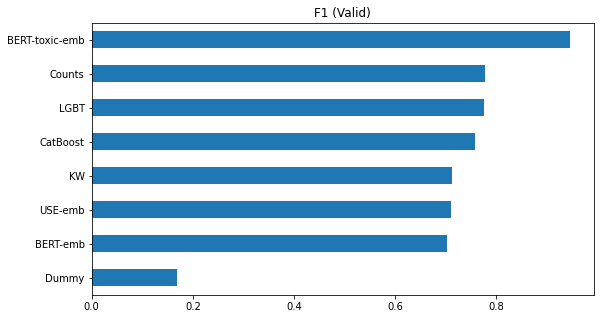

In [130]:
(
    pd.DataFrame(stat)
        .transpose()
        .sort_values(1)
        .plot(kind='barh', legend=False, figsize=(9,5), title='F1 (Valid)')
);

For the right ensemble, you need to choose the best models of approximately the same quality. Therefore, we take the frequency model and LGBT asFor the right ensemble, you need to choose the best models of approximately the same quality. Therefore, we take the Count model and LGBM. These are not the best models, but they are suitable for our experiment.

In [131]:
class EnsambleModel():
    def __init__(self, m1=stat['LGBT'][0], m2=stat['Counts'][0]):
        self.m1 = m1
        self.m2 = m2
    
    def fit(self, df_f, df_t):
        pass
        
    def predict(self, df_f):
        p1 = self.m1.predict_proba(df_f)
        p2 = self.m2.predict_proba(df_f)
        
        p = [0] * len(p1)
        for i in range(len(p1)):
            if p2[i] < 0.55:
                p[i] = 0;
            elif p2[i] > 0.8:
                p[i] = 1
            else:
                p[i] = p1[i]
              
        return p

In [132]:
res = train_model(EnsambleModel())

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     28385
           1       0.82      0.75      0.79      3206

    accuracy                           0.96     31591
   macro avg       0.90      0.87      0.88     31591
weighted avg       0.96      0.96      0.96     31591

f1 valid = 0.7853539462978031


In [133]:
stat['Ensamble'] = res

**Resume:** Due to the ensemble, the metric was increased by almost 1%

### Consulation <a class="anchor" id="model-consulation"></a>

- modeled several interesting architectures
- prepared keyword search functions
- frequency analysis models have good (but not the best) results
- the threshold was also selected as a hyperparameter
- in my project pure embeddings lost out to frequency ones (tf network showed the best results at the output, I tried other classifiers from simple to complex)
- retrained models are much better than embodings, but require significant resources for training
- toxic-specific pretrained bert model has the best score (except may be fine tuning bert model)
- embeddings can be used not only for classification, for example, the search for correlations and similarity of sentences
- the use of ensembles and combinations of models can further increase the metric

## Testing <a class="anchor" id="test"></a>
Let's compare the results of different algorithms, choose the best final model for this projectLet's compare the results of different algorithms, choose the best final model for this project

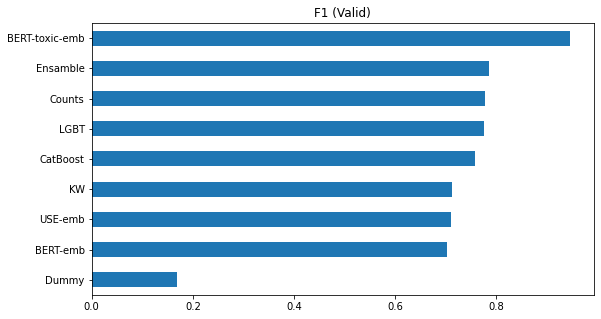

In [134]:
(
    pd.DataFrame(stat)
        .transpose()
        .sort_values(1)
        .plot(kind='barh', legend=False, figsize=(9,5), title='F1 (Valid)')
);

So, the best is BERT-toxic-emb and Ensamble model in second place

In [135]:
# tv_f = train_f.append(valid_f)
# tv_t = train_t.append(valid_t)

# m1 = LGBTModel()
# m1.fit(tv_f, tv_t)

# m2 = CountModel()
# m2.fit(tv_f, tv_t)

# final_model = EnsambleModel(m1=m1, m2=m2)

In [136]:
# eval_model(final_model, test_f, test_t)

In [137]:
tv_f = train_f_e_toxic.append(valid_f_e_toxic)
tv_t = train_t.append(valid_t)

test_f_e_toxic = pd.read_csv('temp/test_f_e_toxic.csv')

res = train_model(BertTxicEmbModel(), train_f=tv_f, train_t=tv_t, valid_f=test_f_e_toxic, valid_t=test_t)

'Этот код выполнялся локально'

**Result:** The final model has the metric **F1 = 0.95** (before BERT-emb-toxic the ensemble had F1=0.79). The result satisfies the requirements at 0.75

## Consulation <a class="anchor" id="consulation"></a>

**Feature Engineering**
- a little more than 1% of messages have length more than 512 words
- selective viewing does not show unnecessary information (texts of forwarded messages, signatures, and so on)
- presumably the emotional coloring fits into the first 512 words, you can limit the number of words when working with BERT.
- processed short messages, some deleted
- carried out lemmantization
- prepared function for creating TF-IDF features

**EDA**
- there is a class imbalance
- there is a class difference in TF-IDF
- there is a class difference in word frequencies
- visually the difference between ghosts in TF-IDF is more significant
- prepared lists of keywords in different ways
- prepared an algorithm for identifying class-specific keywords
- non-toxic messages are on average longer (differences are not significant enough to be used as a feature)

**Modeling**
- modeled several interesting architectures
- prepared keyword search functions
- frequency analysis models have good (but not the best) results
- the threshold was also selected as a hyperparameter
- in my project pure embeddings lost out to frequency ones (tf network showed the best results at the output, I tried other classifiers from simple to complex)
- retrained models are much better than embodings, but require significant resources for training
- toxic-specific pretrained bert model has the best score (except may be fine tuning bert model)
- embeddings can be used not only for classification, for example, the search for correlations and similarity of sentences
- the use of ensembles and combinations of models can further increase the metric

**Testing** 

- The final model has the metric **F1 = 0.95** (before BERT-emb-toxic the ensemble had F1=0.79). The result satisfies the requirements at 0.75

## References
- BERT in DeepPavlov http://docs.deeppavlov.ai/en/master/features/models/bert.html
- NLP Tutorial for Text Classification in Python https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
- universal-sentence-encoder https://tfhub.dev/s?q=universal%20sentence%20encoder
- Semantic Textual Similarity Task Example - https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
- В руководстве используется облегченная модель bert http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
- Sentences Embedding Visualization – How to do it the Best Way https://inside-machinelearning.com/en/efficient-sentences-embedding-visualization-tsne/
- Ещё одно обучение BERT и сравнение с CatBoost https://towardsdatascience.com/unconventional-sentiment-analysis-bert-vs-catboost-90645f2437a9
- Вот вариант, где обрабатыввают весь текст, а не только 512, https://medium.com/analytics-vidhya/bert-embedding-for-classification-7c51aead26d9